# Churn Prediction System

## Latar Belakang

Pada Industri Telekomunikasi, Customer churn (Berhenti Berlangganan) jadi masalah utama, rata rata churn 15-25%.

kerugiannya dari menarik pelanggan baru 5-10x lebih mahal dari pada menjaga yang lama

Dengan simple math. kita bisa simpulin, kalo perusahaan dengan 1 juta pelanggan. dan APRU(Average Revenue Per User) $50. kalau churnya 25%. maka pendapatan bisa hilang sampai $200 jt per tahun.

Customer Lifetime Value (CLTV) digunakan sebagai pengukuran kesehatan bisnis jangka panjang. penurunan churn sekecil 1% bisameningkatkan laba sampe 5%. kalo 5%, profit bisa naik sampe 50%. the point is. strategi mempertahankan ini punya ROI yang sangat tinggi.

Sebenarnya, churn bisa mengunkap bahwa ada kesalahan dalam bisnis. churn ningkat kalo layanan emang buruk atau tidak bisa hanle jagnka panjang. 

## Tujuan Projek :

Membangun sistem machine learning untuk prediksi pelanggan yang berisiko churn. dan juga mengunkap alasan di baliknya. Hasil analisis ini diharapkan bisa mendukung stratefi retensi yang efisien.

## Dataset :

https://www.kaggle.com/datasets/blastchar/telco-customer-churn?utm_source=chatgpt.com

dataset yang digunakan adalah Telco Customer Churn dari kaggle, metodologi dari eda sampai deployment.

In [9]:
# Import library yang dibutuhkan
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from IPython.display import display

# Konfigurasi visualisasi
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# Library untuk preprocessing dan modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb

# Mengabaikan warning untuk kebersihan output
import warnings
warnings.filterwarnings('ignore')

## EDA (Exploratory Data Analysis)

mahamin pola, merumuskan hipotesis awal, cek validasi data.

### Datasets

In [8]:
# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)
print(f"File yang tersedia:{os.listdir(path)}")

Path to dataset files: /Users/ryanakmalpasya/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1
File yang tersedia:['WA_Fn-UseC_-Telco-Customer-Churn.csv']


In [10]:
# Membaca dataset
df = pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Menampilkan 5 baris pertama
print("Data Awal:")
display(df.head())

# Menampilkan info dasar dataset
print("\nInformasi Dataset:")
df.info()

Data Awal:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043

### Datasets Overview

| Kolom                | Deskripsi                                                                 |
|----------------------|---------------------------------------------------------------------------|
| `customerID`         | ID unik untuk setiap pelanggan. Tidak berguna untuk model prediktif.      |
| `gender`             | Jenis kelamin pelanggan: `Male` atau `Female`.                            |
| `SeniorCitizen`      | Apakah pelanggan adalah warga senior (1 = Ya, 0 = Tidak).                 |
| `Partner`            | Apakah pelanggan memiliki pasangan (married).                             |
| `Dependents`         | Apakah pelanggan memiliki tanggungan (anak/orang tua).                    |
| `tenure`             | Lama pelanggan berlangganan (dalam bulan).                                |
| `PhoneService`       | Apakah pelanggan memiliki layanan telepon.                                |
| `MultipleLines`      | Apakah pelanggan memiliki lebih dari satu saluran telepon.                |
| `InternetService`    | Jenis layanan internet: `DSL`, `Fiber optic`, atau `No`.                  |
| `OnlineSecurity`     | Apakah pelanggan memiliki layanan keamanan online.                        |
| `OnlineBackup`       | Apakah pelanggan memiliki layanan backup online.                          |
| `DeviceProtection`   | Apakah pelanggan memiliki perlindungan perangkat.                         |
| `TechSupport`        | Apakah pelanggan memiliki dukungan teknis.                                |
| `StreamingTV`        | Apakah pelanggan berlangganan streaming TV.                               |
| `StreamingMovies`    | Apakah pelanggan berlangganan streaming film.                             |
| `Contract`           | Jenis kontrak: `Month-to-month`, `One year`, `Two year`.                  |
| `PaperlessBilling`   | Apakah pelanggan menggunakan tagihan tanpa kertas.                        |
| `PaymentMethod`      | Metode pembayaran: misalnya `Electronic check`, `Credit card`, dll.       |
| `MonthlyCharges`     | Jumlah tagihan bulanan pelanggan.                                         |
| `TotalCharges`       | Total tagihan yang dibayar selama menjadi pelanggan. (Perlu konversi)     |
| `Churn`              | Target variabel: apakah pelanggan berhenti (`Yes`) atau tetap (`No`).     |

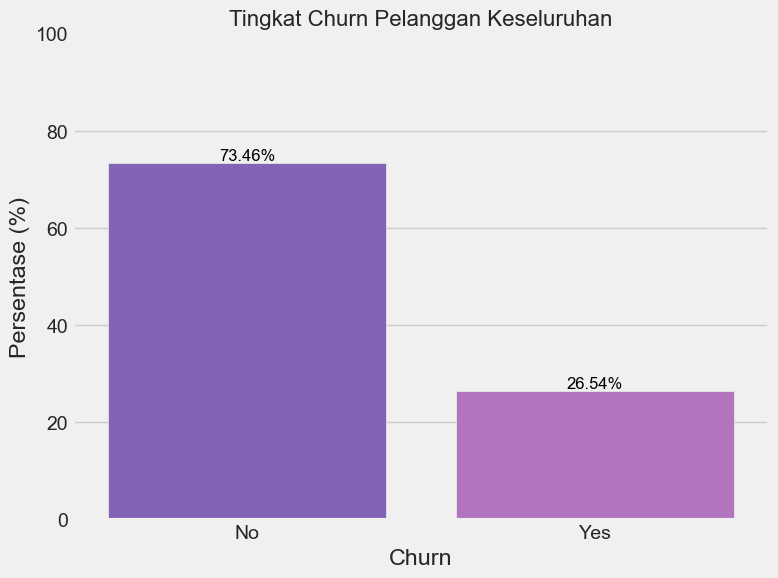

Tingkat Churn:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [19]:
# Menghitung dan memvisualisasikan tingkat churn
churn_rate = df['Churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=churn_rate.index, y=churn_rate.values, palette = ['#7E57C2', '#BA68C8'])
plt.title('Tingkat Churn Pelanggan Keseluruhan', fontsize=16)
plt.ylabel('Persentase (%)')
plt.xlabel('Churn')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.ylim(0, 100)
plt.show()

print(f"Tingkat Churn:\n{churn_rate}")

**Analisis :** 

Sekitar 26.54% pelanggan telah churn. Ini merupakan tingkat churn yang signifikan dan mengonfirmasi bahwa dataset ini tidak seimbang (imbalanced). Ketidakseimbangan ini menjadi pertimbangan krusial yang akan memengaruhi strategi pemodelan dan metrik evaluasi kita.


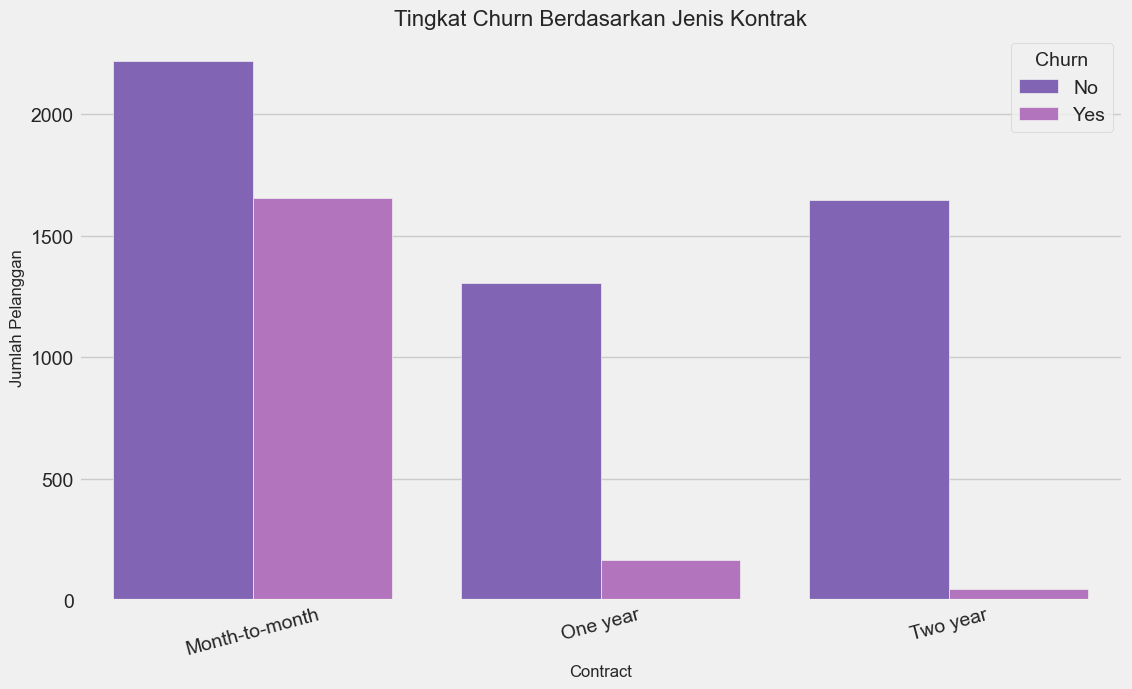

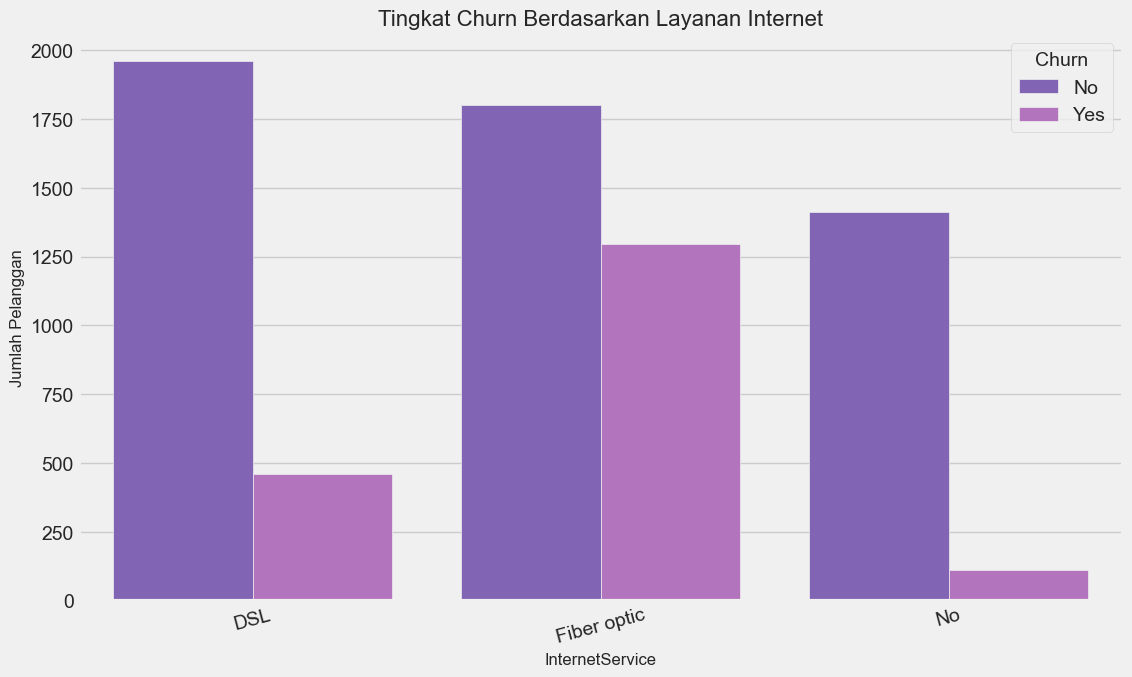

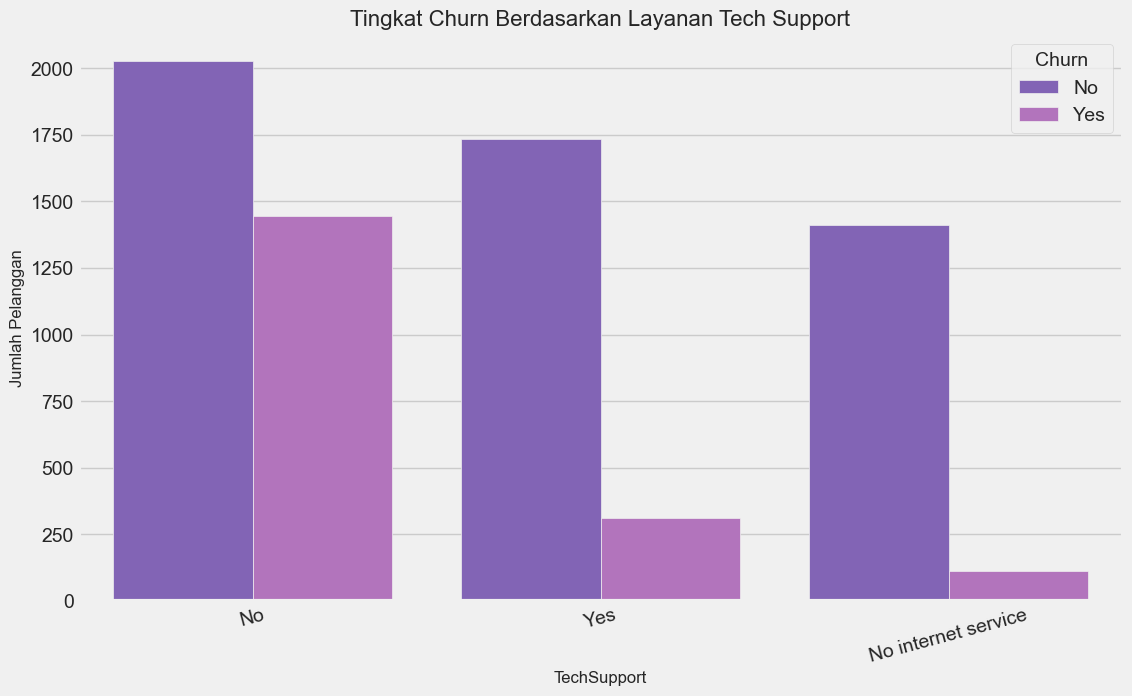

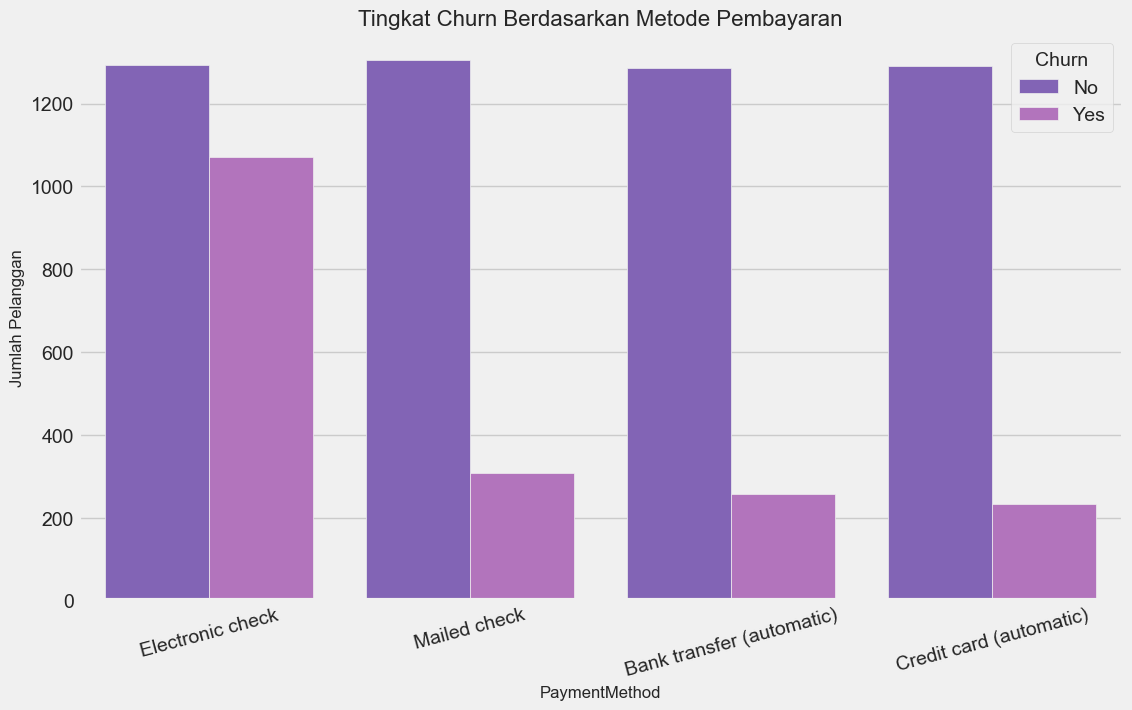

In [20]:
# Fungsi untuk membuat plot fitur kategorikal vs churn
def plot_categorical_vs_churn(feature, title):
    plt.figure(figsize=(12, 7))
    ax = sns.countplot(x=feature, hue='Churn', data=df, palette = ['#7E57C2', '#BA68C8'])
    plt.title(title, fontsize=16)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Jumlah Pelanggan', fontsize=12)
    plt.xticks(rotation=15)
    
    # Hitung persentase churn (Yes) untuk setiap kategori
    churn_percent = df[df['Churn'] == 'Yes'].groupby(feature).size() / df.groupby(feature).size() * 100
    churn_percent = churn_percent.round(1)

    # Tambahkan anotasi persentase churn di atas bar
    for p in ax.patches:
        category = p.get_x() + p.get_width() / 2
        height = p.get_height()
        if p.get_label() == 'Churn=Yes':
            cat_idx = int(p.get_x() + p.get_width() / 2)
            plt.text(category, height + 5, f'{int(height)}', ha='center', fontsize=10)

    plt.legend(title='Churn')
    plt.show()
    
# Visualisasi untuk fitur-fitur penting
plot_categorical_vs_churn('Contract', 'Tingkat Churn Berdasarkan Jenis Kontrak')
plot_categorical_vs_churn('InternetService', 'Tingkat Churn Berdasarkan Layanan Internet')
plot_categorical_vs_churn('TechSupport', 'Tingkat Churn Berdasarkan Layanan Tech Support')
plot_categorical_vs_churn('PaymentMethod', 'Tingkat Churn Berdasarkan Metode Pembayaran')

**Analisis :**

Jenis Kontrak (Contract): Pelanggan dengan kontrak Month-to-month memiliki tingkat churn yang sangat tinggi (42.7%) dibandingkan dengan kontrak One year (11.3%) dan Two year (2.8%). Insight : *Komitmen jangka panjang adalah faktor retensi yang kuat*

Layanan Internet (InternetService): Pelanggan dengan layanan Fiber optic memiliki tingkat churn tertinggi (41.9%). Pelanggan tanpa layanan internet memiliki tingkat churn yang sangat rendah (7.4%). Insight : Masalah pada kualitas layanan fiber optic, mungkin harga ga sepadan dengan layanan.

Layanan Tambahan (Contoh: TechSupport): Pelanggan yang tidak berlangganan layanan tambahan seperti TechSupport (tingkat churn 41.6%) atau OnlineSecurity (tingkat churn 41.8%, tidak ditampilkan) jauh lebih mungkin untuk churn. Insight : layanan ini lebih mengikat pelanggan untuk menggunakan layanan internet.

Metode Pembayaran (PaymentMethod): Pelanggan yang menggunakan Electronic check sebagai metode pembayaran menunjukkan tingkat churn yang jauh lebih tinggi (45.3%) dibandingkan metode pembayaran otomatis seperti transfer bank atau kartu kredit. Insight : Metode pembayaran elektronik cenderung lebih berisiko untuk churn, mungkin karena kesulitan dalam transaksi atau kebingungan dalam pembayaran. atau metode tradisional lebih fleksibel dan kasih kesempatan untuk pelanggan mempertimbangkan kembali layanan mereka.


### Analisis Fitur Numerik

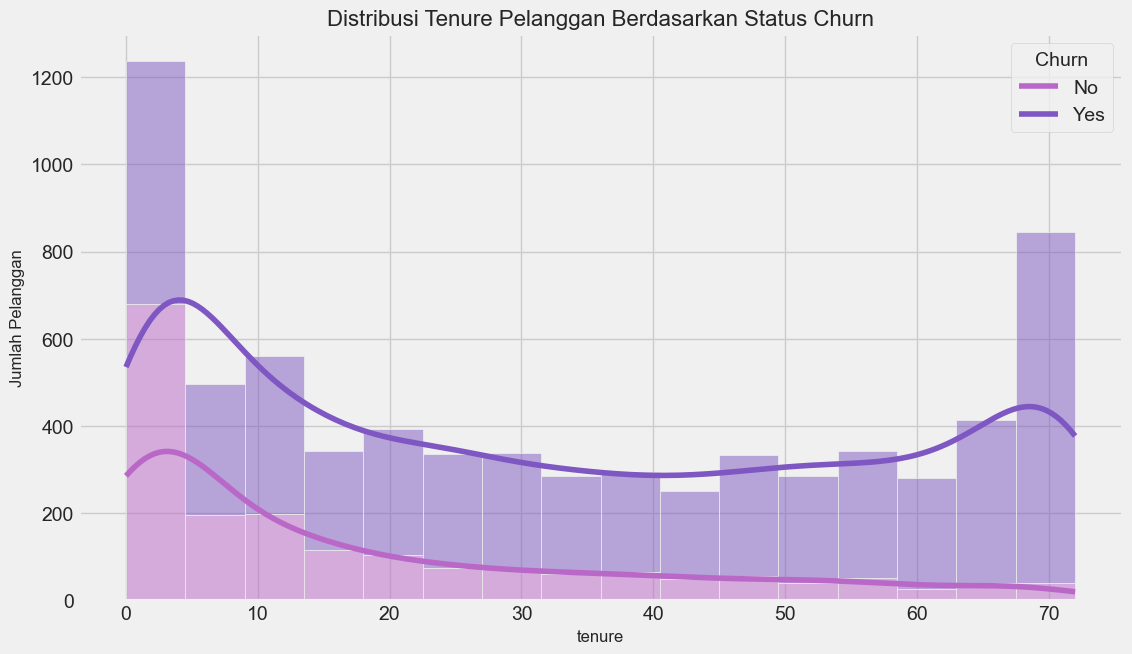

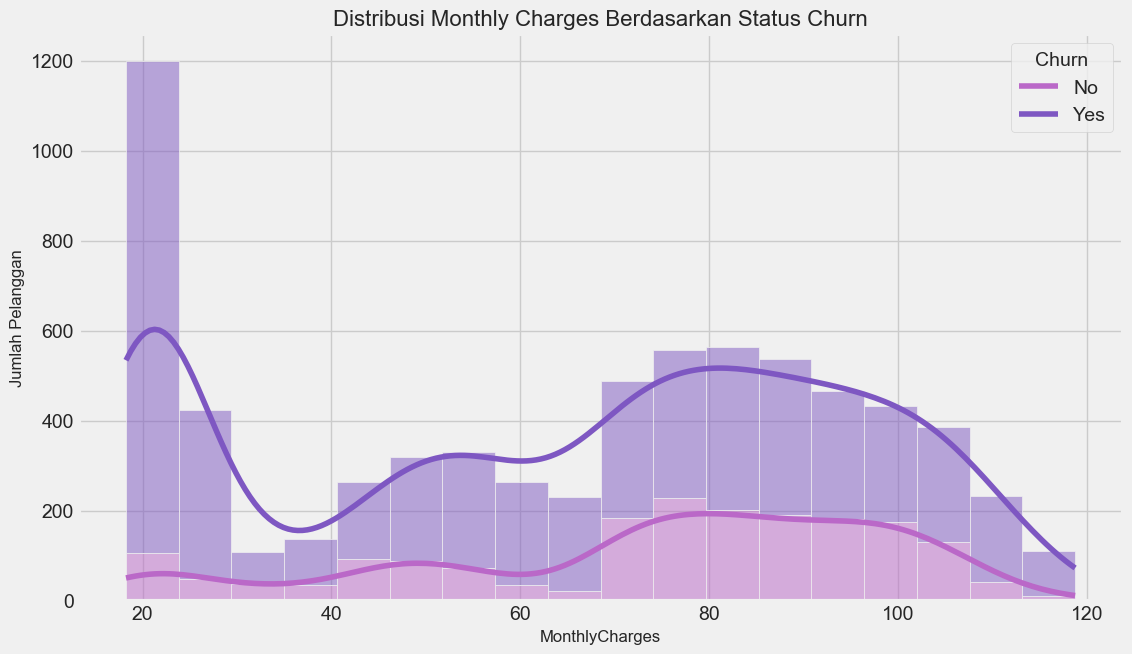

In [18]:
# Fungsi untuk membuat plot fitur numerik vs churn
def plot_numerical_vs_churn(feature, title):
    plt.figure(figsize=(12, 7))
    sns.histplot(data=df, x=feature, hue='Churn', multiple='stack', kde=True, palette=['#7E57C2', '#BA68C8'])
    plt.title(title, fontsize=16)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Jumlah Pelanggan', fontsize=12)
    plt.legend(title='Churn', labels=['No', 'Yes'])
    plt.show()

# Visualisasi untuk fitur-fitur numerik
plot_numerical_vs_churn('tenure', 'Distribusi Tenure Pelanggan Berdasarkan Status Churn')
plot_numerical_vs_churn('MonthlyCharges', 'Distribusi Monthly Charges Berdasarkan Status Churn')

**Analisis :**

Distribusi Tenure Berdasarkan Status Churn
- Pelanggan baru (<10 bulan) memiliki tingkat churn tertinggi. Hal ini menunjukkan bahwa banyak pelanggan keluar pada fase awal langganan.
- Setelah melewati bulan ke-10, churn menurun drastis dan cenderung stabil. Artinya, semakin lama pelanggan bertahan, semakin kecil kemungkinan mereka untuk berhenti.
- Terdapat peningkatan pelanggan loyal dengan tenure tinggi (sekitar 70 bulan), yang hampir tidak mengalami churn.

Insight:
- Kritikalnya fase onboarding: Perusahaan perlu fokus pada pengalaman pelanggan di 10 bulan pertama, seperti peningkatan customer support, welcome program, atau edukasi produk.
- Retention early-stage adalah kunci menurunkan churn jangka panjang.


Distribusi Monthly Charges Berdasarkan Status Churn
- hurn paling tinggi terjadi pada pelanggan dengan tagihan bulanan di atas $70–$100.
- Sebaliknya, pelanggan dengan tagihan lebih rendah ($20–$60) memiliki churn yang jauh lebih rendah.
- Ini menunjukkan bahwa tingginya biaya tidak selalu diimbangi dengan kepuasan layanan.

Insight:
- Ada kemungkinan “value perception gap”, di mana pelanggan merasa biaya tidak sebanding dengan kualitas atau manfaat yang mereka terima.
- Perlu dilakukan value re-alignment seperti:
- Penyesuaian harga paket
- Komunikasi manfaat layanan yang lebih baik
- Penambahan fitur untuk pelanggan high-paying


### Analisis Korelasi

Heatmap korelasi membantu kita memahami hubungan antar fitur numerik dan mengidentifikasi potensi multikolinearitas.

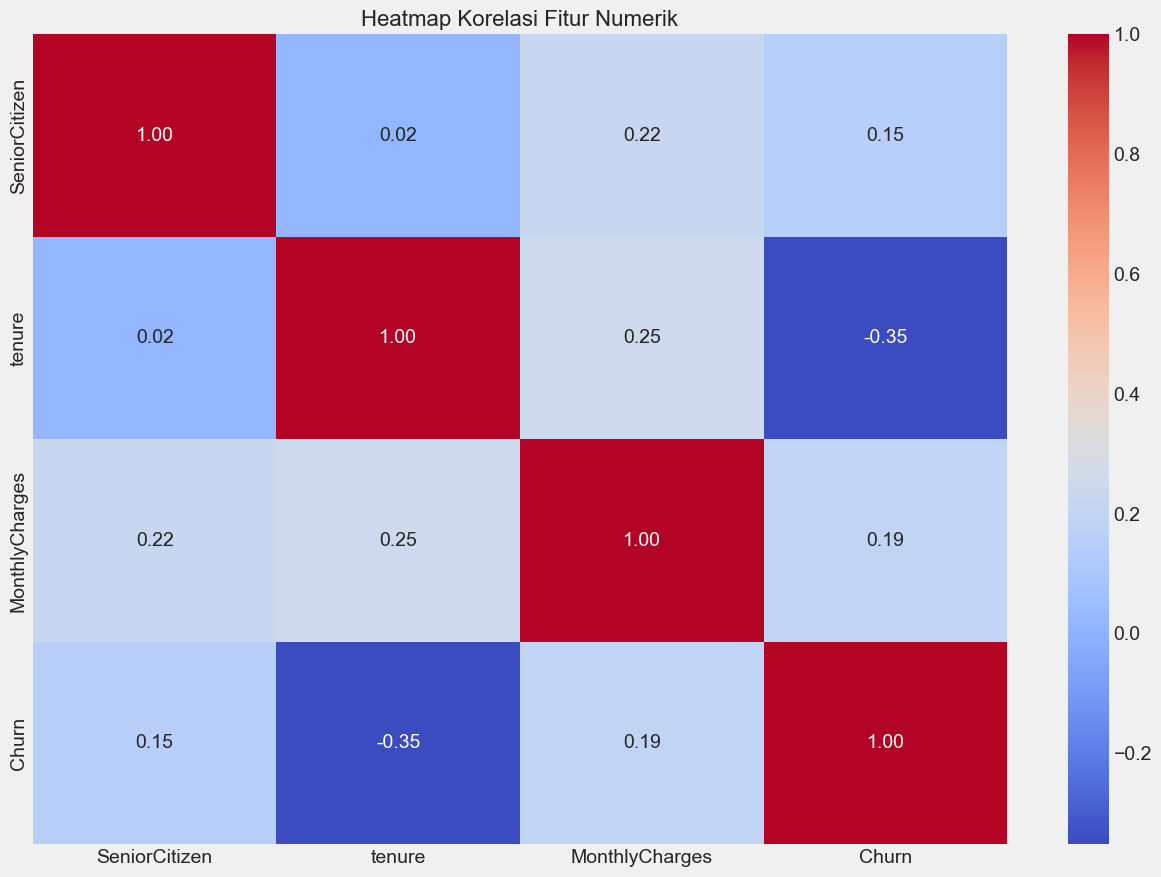

In [21]:
# Mengubah 'Churn' menjadi numerik untuk korelasi
df_corr = df.copy()
df_corr['Churn'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})

# Menghitung matriks korelasi
plt.figure(figsize=(14, 10))
# Mengonversi kolom non-numerik yang relevan
numeric_cols = df_corr.select_dtypes(include=np.number).columns
correlation_matrix = df_corr[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Fitur Numerik', fontsize=16)
plt.show()